# Truncated regression in PyMC3
**Author:** [Ben Vincent](https://github.com/drbenvincent)

This notebook provides an example of how to do linear regression in the case where you have truncated observations. Truncation and censoring are both missing data problems:
- **censored data:** data outside the range of some measurement limits are set at those floor and ceiling values
- **truncated data:** data outside the range of some measurement limits are simply absent.

In this notebook we consider interval truncation, where we have both upper and lower truncation bounds.

We simulate some true data, then apply truncation bounds. We fit a standard linear regression model to both the raw and the truncated datasets to see that our estimates may be biased. Then we look at a truncated regression model which uses `pm.TruncatedNormal` for the likelihood function.

Optional: If you want to use autoformatter, then 

    pip install nb-black

In [1]:
%load_ext lab_black

In [2]:
import numpy as np
import pandas as pd

# plotting
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

plt.rcParams.update({"font.size": 14})

import pymc3 as pm
import arviz as az
from scipy.stats import multivariate_normal

print(f"Running on PyMC3 v{pm.__version__}")

Running on PyMC3 v3.7


## Define options

In [3]:
SEED = 123

n_samples = 1_000
m = 1
c = 0
N = 100

truncation_bounds = [-1.5, 1.5]

sample_options = {
    "tune": 1_000,
    "draws": n_samples,
    "chains": 2,
    "cores": 2,
    "nuts_kwargs": {"target_accept": 0.95},
    "random_seed": SEED,
}

np.random.seed(SEED)

## Create synthetic dataset

In [4]:
def make_data():
    x = np.random.randn(N)
    ϵ = np.random.randn(N) * 0.5
    y = m * x + c + ϵ
    return (x, y)


x, y = make_data()

In [5]:
def truncate_y(x, y, truncation_bounds):
    trunc = (y > truncation_bounds[0]) & (y < truncation_bounds[1])
    return (x[trunc], y[trunc])


xt, yt = truncate_y(x, y, truncation_bounds)

In [6]:
def plot_true(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1)

    x = np.array([-3, 3])
    ax.plot(x, m * x + c, "r", lw=3, label="True")
    ax.legend()

[Text(0, 0.5, 'y'), Text(0.5, 0, 'x'), Text(0.5, 1.0, 'Truncated data')]

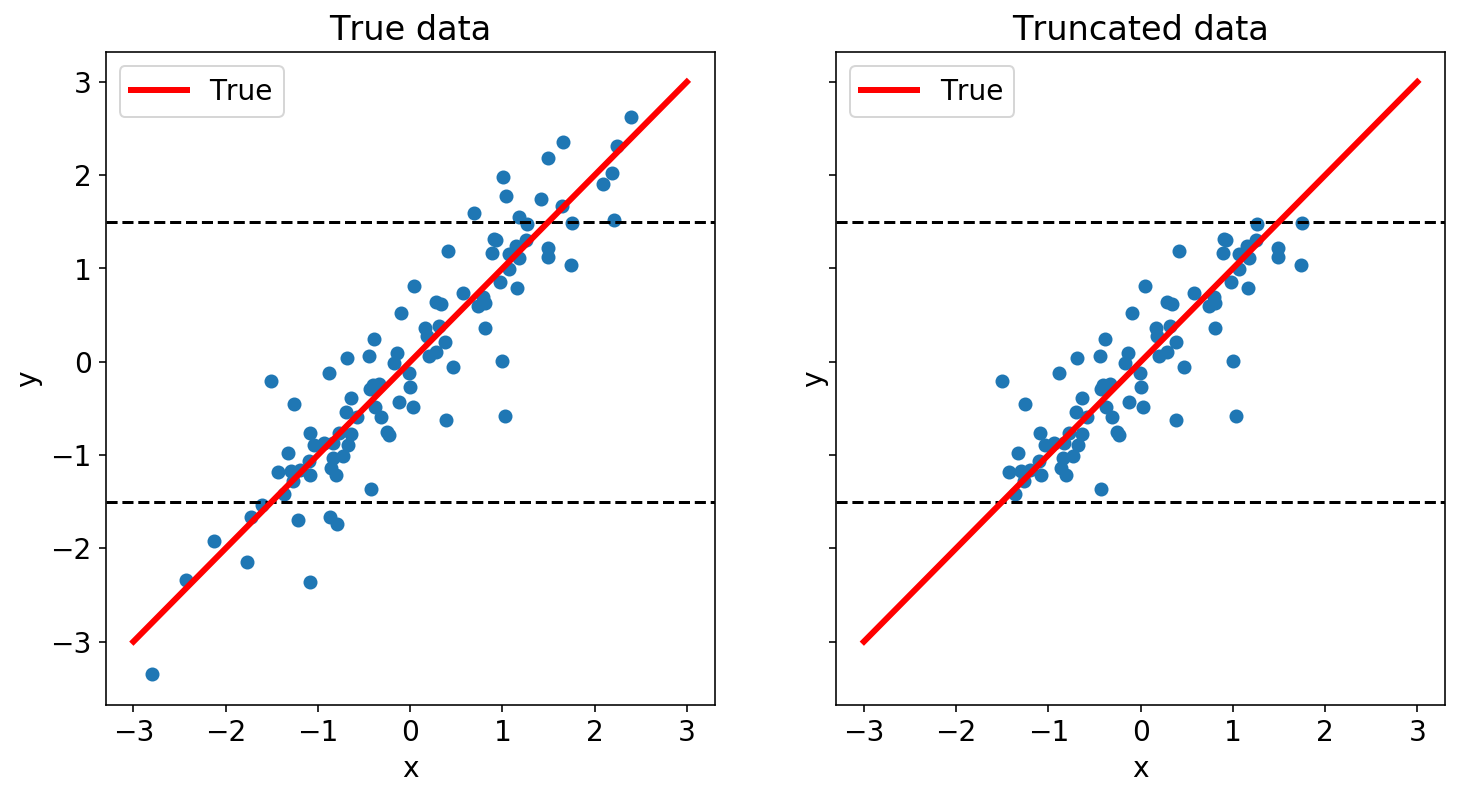

In [7]:
def plot_data(x, y, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1)

    ax.scatter(x, y)
    for bound in truncation_bounds:
        ax.axhline(y=bound, c="k", ls="--")
    ax.set(title="True data", xlabel="x", ylabel="y")
    return ax


fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)

_ = plot_data(x, y, ax=ax[0])
plot_true(ax=ax[0])
ax[0].set(title="True data", xlabel="x", ylabel="y")

_ = plot_data(xt, yt, ax=ax[1])
plot_true(ax=ax[1])
ax[1].set(title="Truncated data", xlabel="x", ylabel="y")

## Regular regression applied to raw and truncated data

In [8]:
def regression(x, y):

    with pm.Model() as model:
        m = pm.Normal("m", mu=0, sd=1)
        c = pm.Normal("c", mu=0, sd=1)
        σ = pm.HalfNormal("σ", sd=1)
        y_likelihood = pm.Normal("y_likelihood", mu=m * x + c, sd=σ, observed=y)

    with model:
        trace = pm.sample(**sample_options)

    return model, trace

In [9]:
model, trace = regression(x, y)
_, trace_t = regression(xt, yt)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, c, m]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:02<00:00, 1379.43draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, c, m]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:02<00:00, 1799.31draws/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c2998ed90>,
      dtype=object)

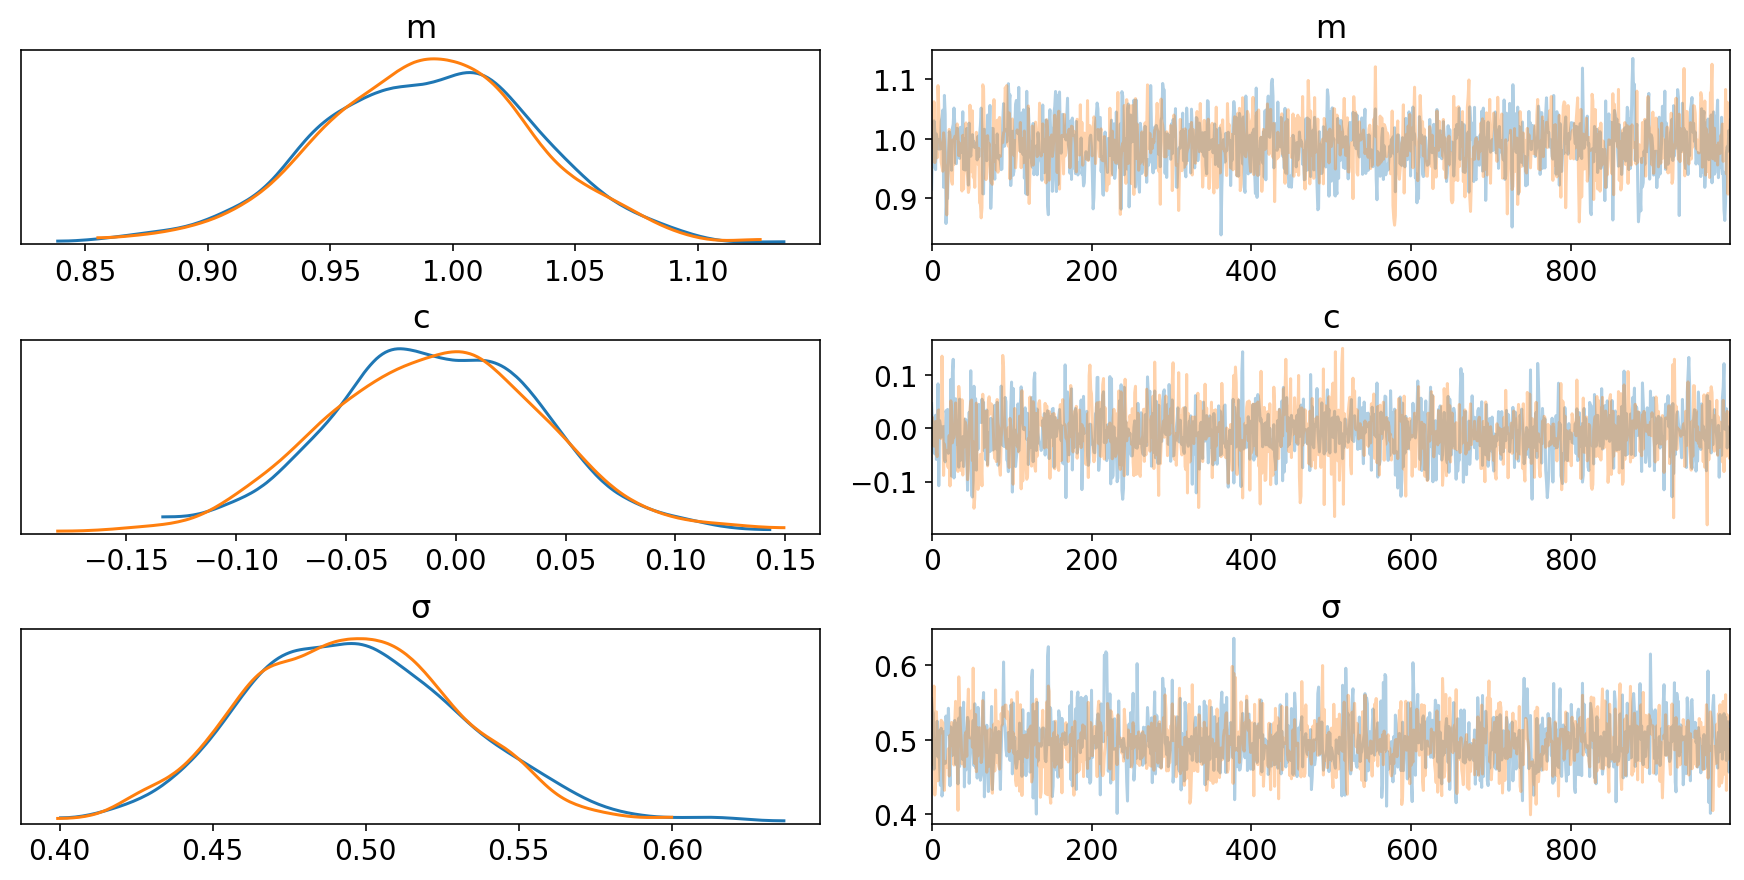

In [10]:
pm.traceplot(trace, var_names=["m", "c", "σ"])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c2f82ef90>,
      dtype=object)

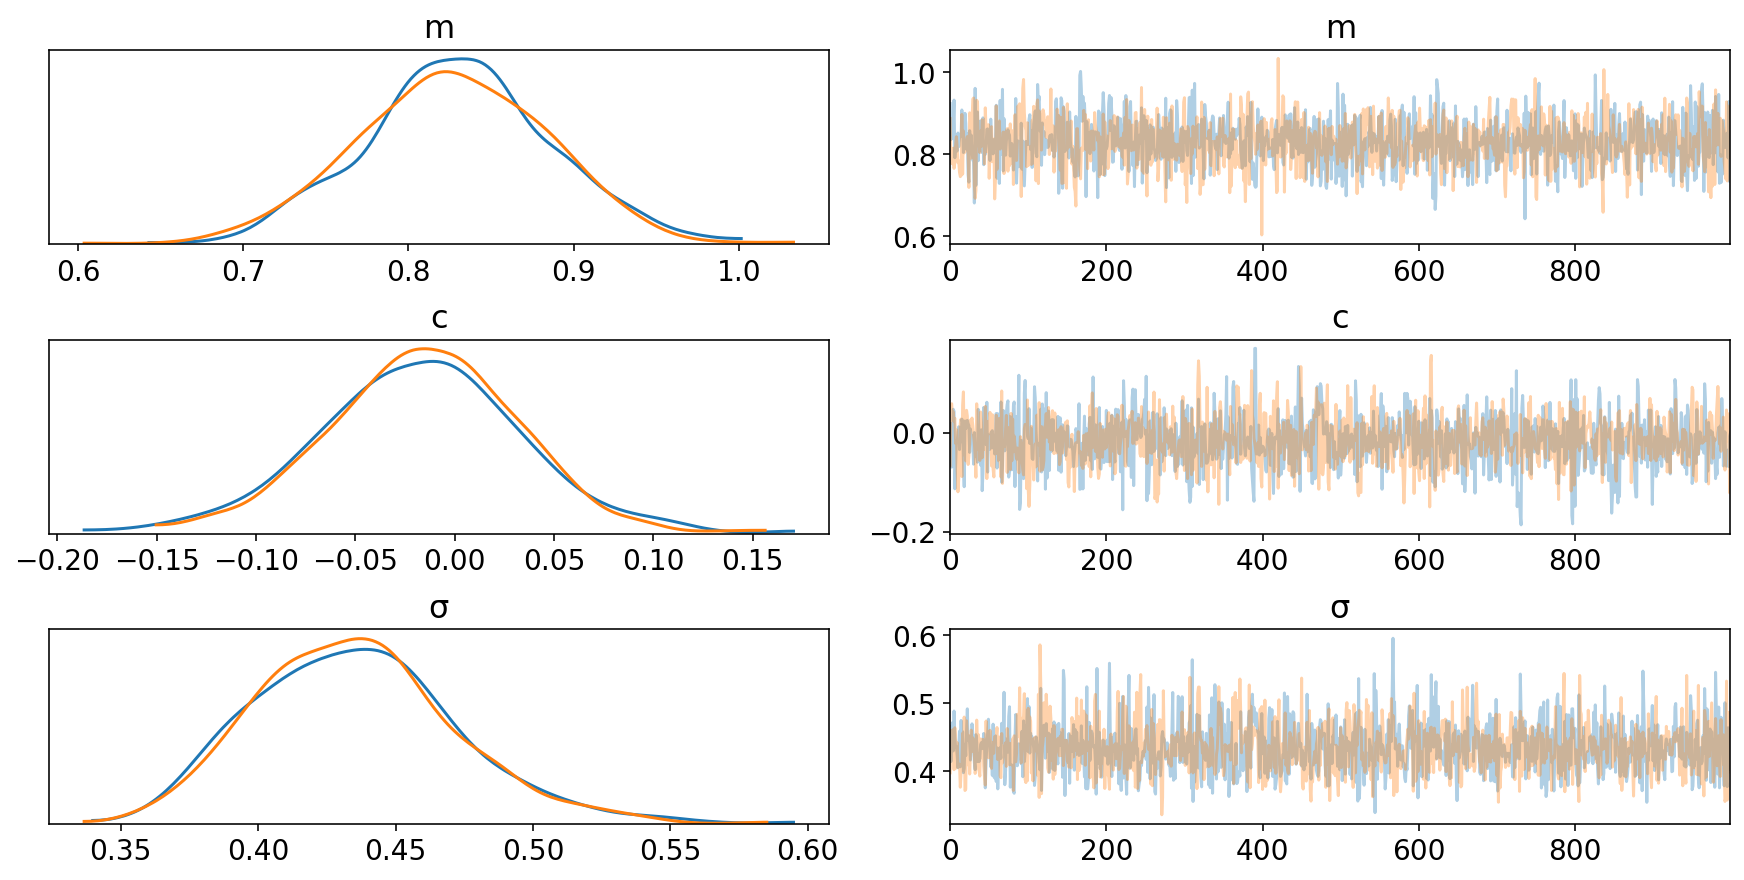

In [11]:
pm.traceplot(trace_t, var_names=["m", "c", "σ"])

## Truncated regression

In [12]:
def truncated_regression(x, y):
    """Sample from a truncated linear regression model"""

    with pm.Model() as model:
        m = pm.Normal("m", mu=0, sd=1)
        c = pm.Normal("c", mu=0, sd=1)
        σ = pm.HalfNormal("σ", sd=1)
        y_likelihood = pm.TruncatedNormal(
            "y_likelihood",
            mu=m * x + c,
            sd=σ,
            observed=y,
            lower=truncation_bounds[0],
            upper=truncation_bounds[1],
        )

    with model:
        trace = pm.sample(**sample_options)

    return model, trace

In [13]:
_, trace_truncated = truncated_regression(xt, yt)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, c, m]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:06<00:00, 657.77draws/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c488c6190>,
      dtype=object)

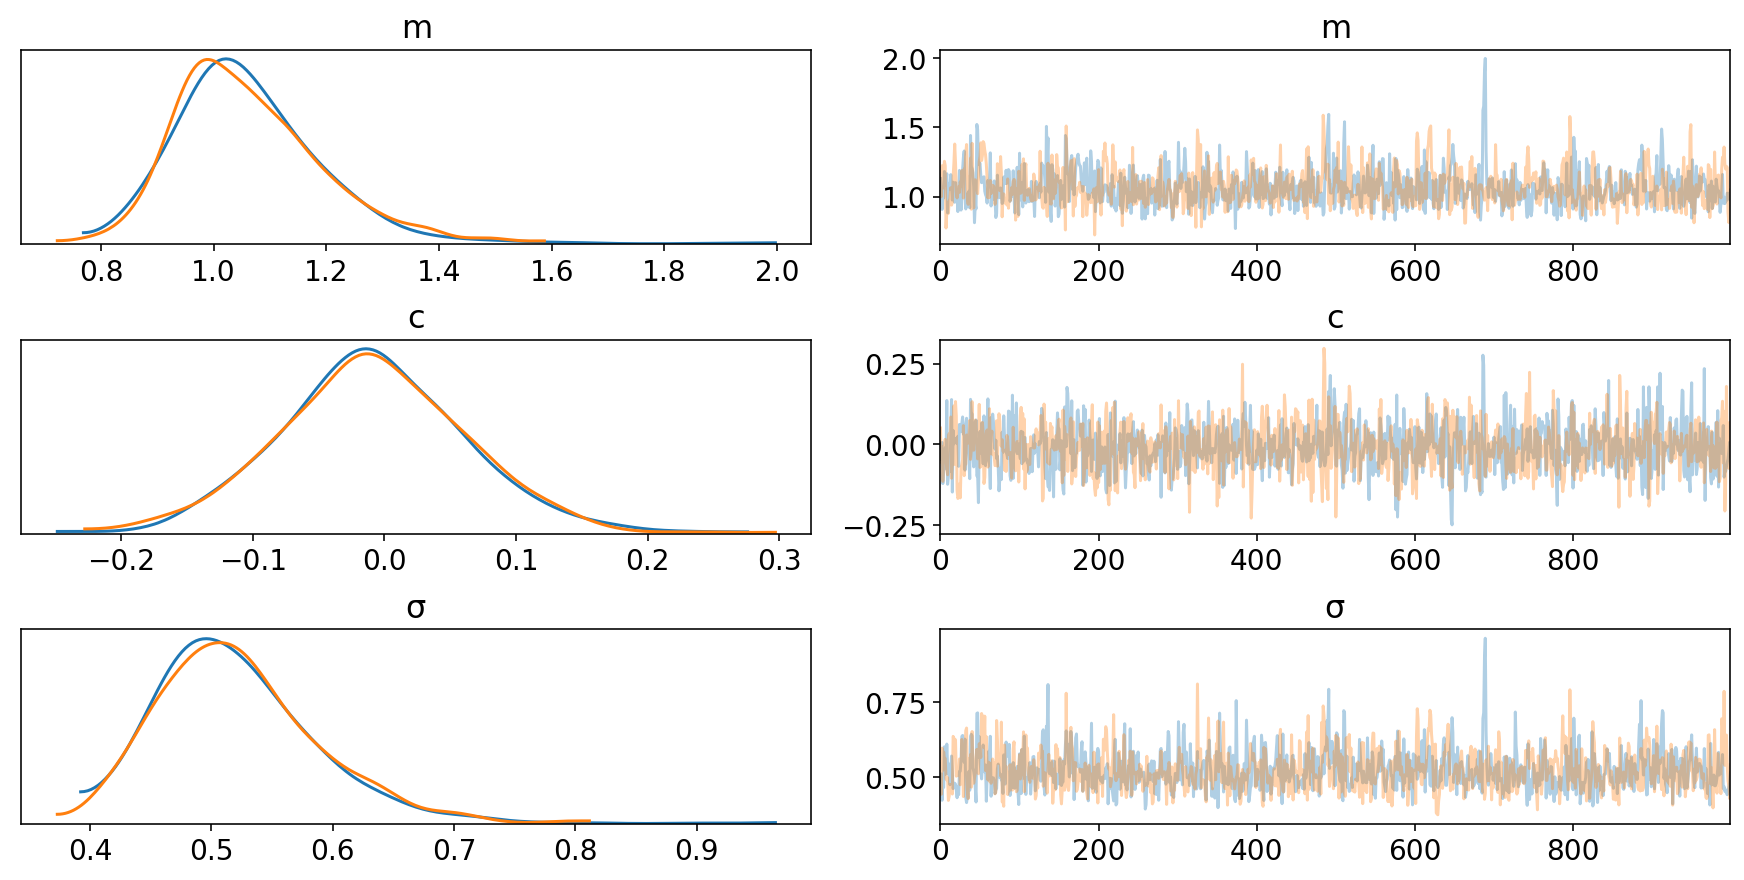

In [14]:
pm.traceplot(trace_truncated, var_names=["m", "c", "σ"])

## Visualise everything

In [15]:
def plot_posterior_predictive(trace, ax=None):

    if ax is None:
        fig, ax = plt.subplots()

    # plot posterior predictive
    x_ppc = np.array([-3, +3])

    for n in range(n_samples):
        y_ppc = x_ppc * trace["m"][n] + trace["c"][n]
        ax.plot(x_ppc, y_ppc, "k", alpha=0.01, rasterized=True)

    return ax

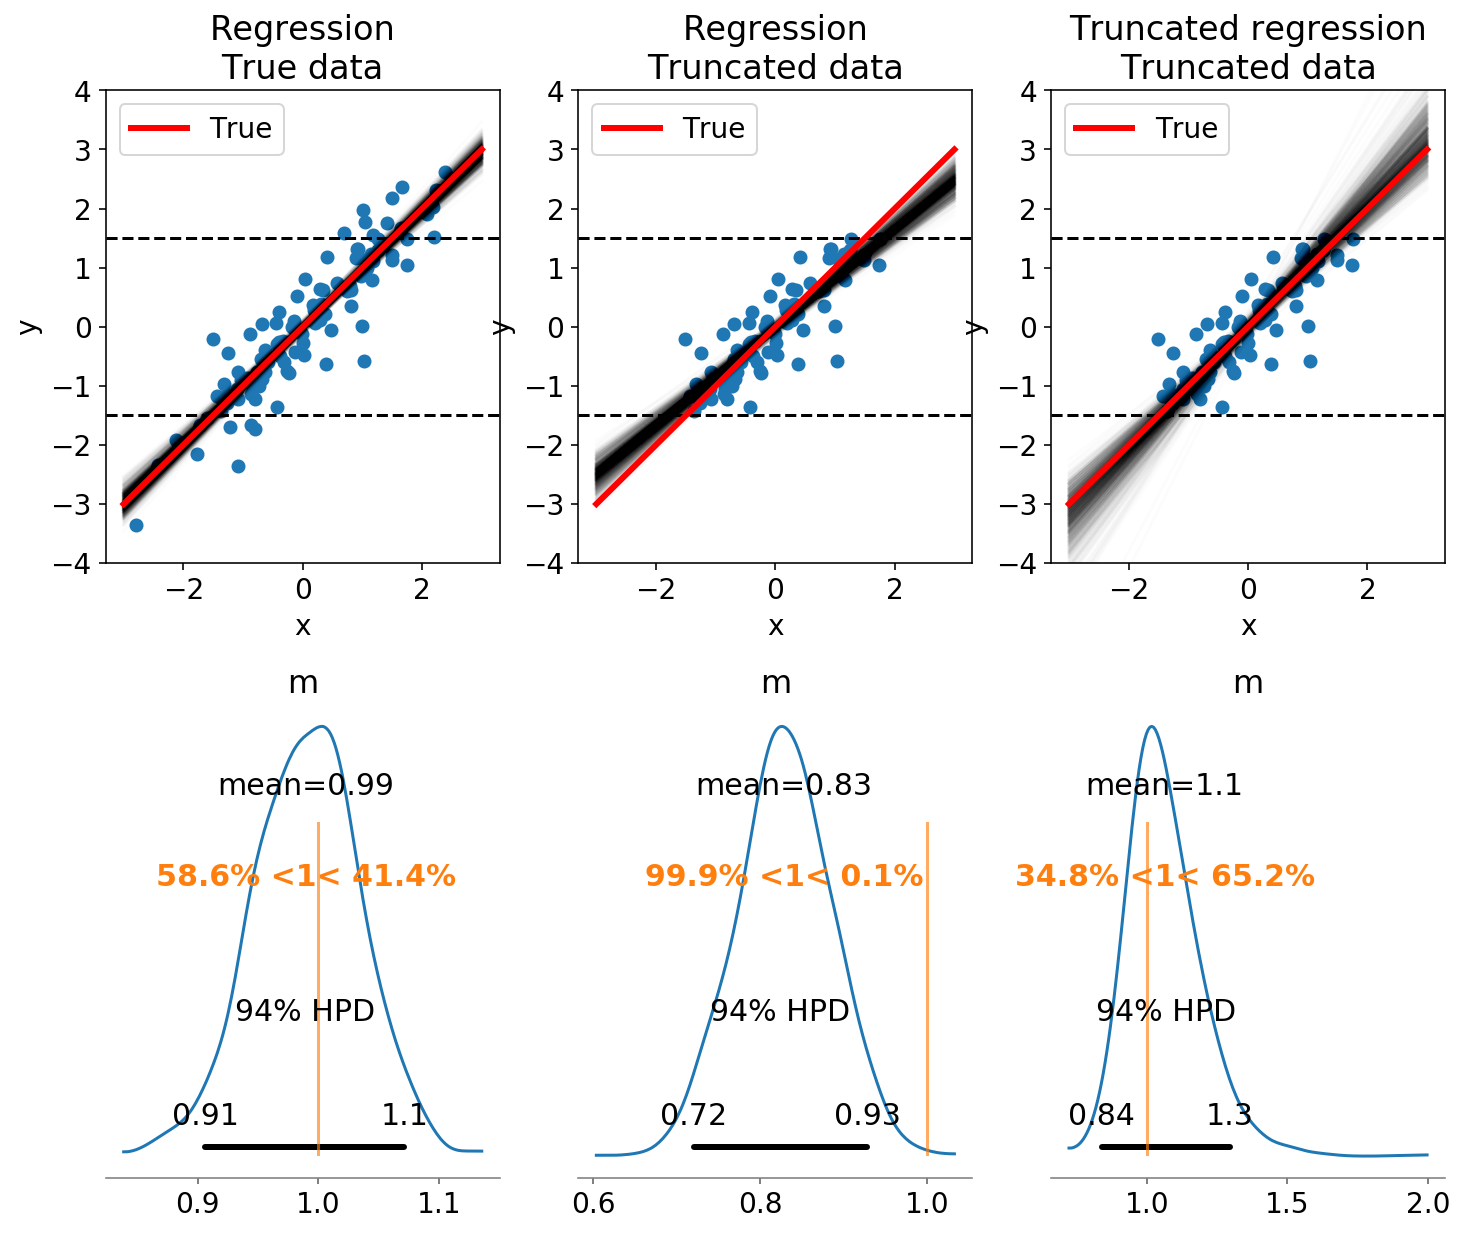

In [16]:
xfig, ax = plt.subplots(2, 3, figsize=(12, 10))

data_ylim = [-4, 4]

# True data =================================================
# data space
_ = plot_data(x, y, ax=ax[0, 0])
_ = plot_posterior_predictive(trace, ax=ax[0, 0])
ax[0, 0].set(title="Regression\nTrue data", xlabel="x", ylabel="y", ylim=data_ylim)
plot_true(ax=ax[0, 0])
# parameter space
az.plot_posterior(trace, var_names=["m"], ax=ax[1, 0], ref_val=m)

# Truncated data ============================================
_ = plot_data(xt, yt, ax=ax[0, 1])
ax[0, 1].set(title="Regression\nTruncated data", xlabel="x", ylabel="y", ylim=data_ylim)
_ = plot_posterior_predictive(trace_t, ax=ax[0, 1])
plot_true(ax=ax[0, 1])
# parameter space
az.plot_posterior(trace_t, var_names=["m"], ax=ax[1, 1], ref_val=m)

# Truncated regression with truncated data ==================
_ = plot_data(xt, yt, ax=ax[0, 2])
ax[0, 2].set(
    title="Truncated regression\nTruncated data", xlabel="x", ylabel="y", ylim=data_ylim
)
_ = plot_posterior_predictive(trace_truncated, ax=ax[0, 2])
plot_true(ax=ax[0, 2])
# parameter space
az.plot_posterior(trace_truncated, var_names=["m"], ax=ax[1, 2], ref_val=m)


# spacing between rows
plt.subplots_adjust(hspace=0.3)

**Left:** As a santiy check, we can do good inference of the slope based upon standard regression using the full dataset.

**Middle:** Using standard regression on our truncated dataset results in bias in our slope estimate.

**Right:** Applying the truncated regression model to the truncated data shows improved inferences about the slope parameter.